In [7]:
%matplotlib inline
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [8]:
def points_for_calibration(images_pattern='camera_cal/calibration*.jpg', nx=9, ny=6):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for name in tqdm(glob.glob(images_pattern)):
        # Convert to grayscale
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, append points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.

In [9]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

objpoints, imgpoints = points_for_calibration()

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration.p", "wb"))

100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

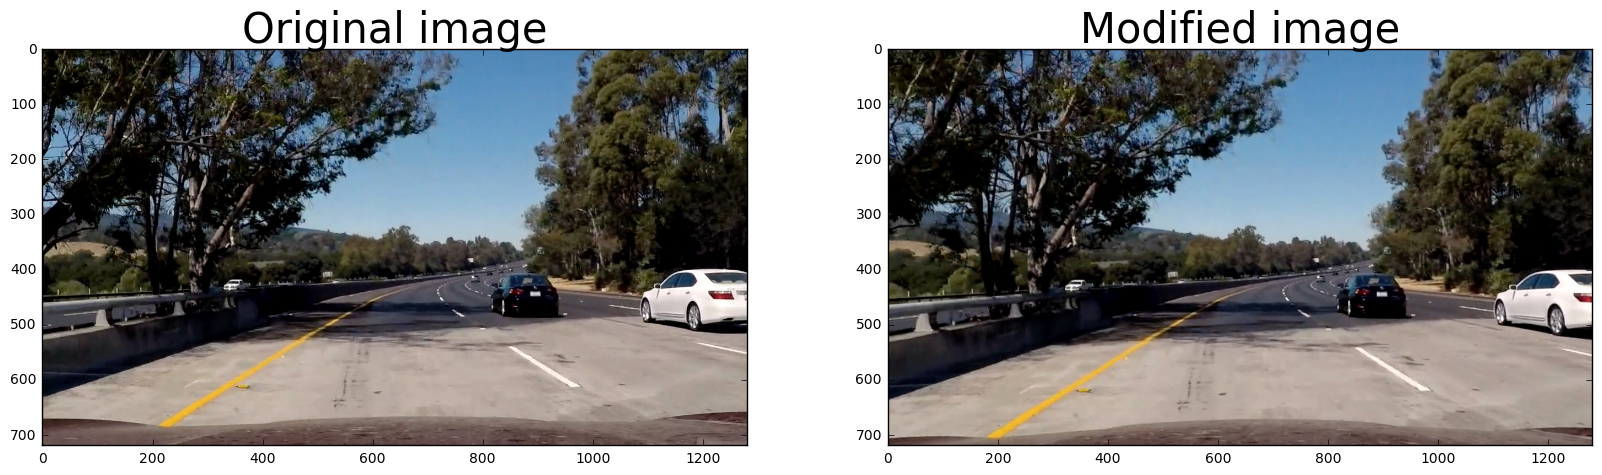

In [12]:
def display_images(img1, img2, title1='Original image', 
                   title2='Modified image', filename=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=30)

    if filename:
        plt.savefig(filename)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
display_images(img, undistorted, filename='output_images/original_undistorted.png')

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text][image2]

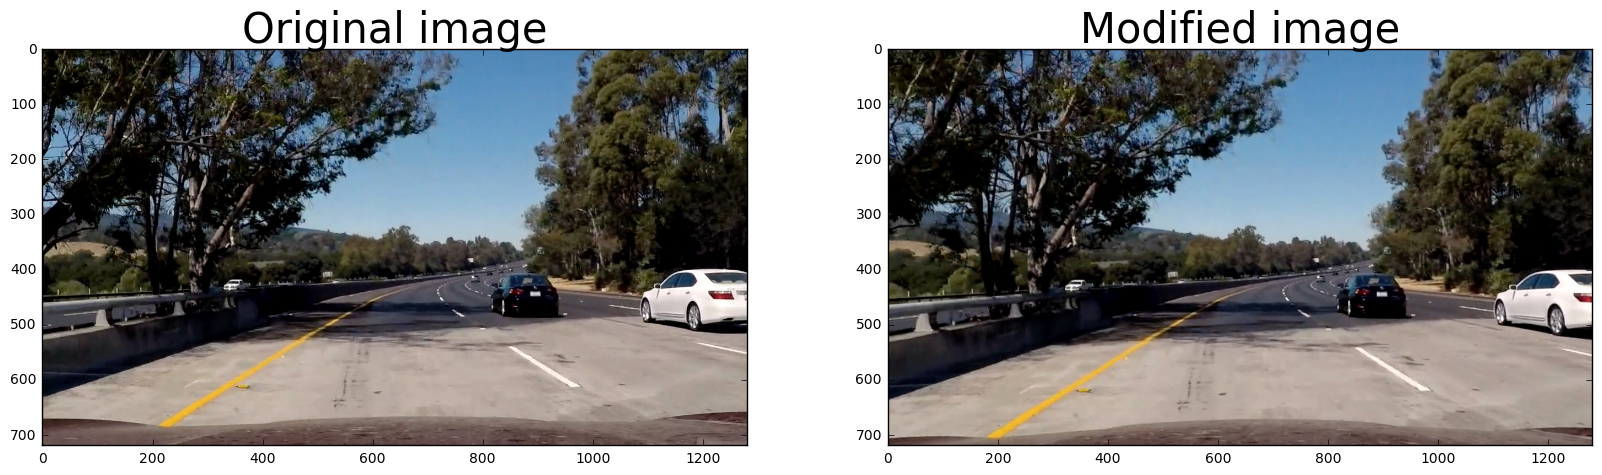

In [13]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

display_images(img, undistorted, filename='output_images/test_original_undistorted.png')

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image.

In [39]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        deriv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        deriv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    deriv = np.absolute(deriv)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    deriv = ((deriv / np.max(deriv)) * 255).astype(np.uint8)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(deriv)
    grad_binary[(deriv > thresh[0]) & (deriv < thresh[1])] = 1
    print(grad_binary.shape)
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    mag = np.sqrt((np.square(sobelx) + np.square(sobely)))
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    mag = ((mag / np.max(mag)) * 255).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag > mag_thresh[0]) & (mag < mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return dir_binary

def color_thresh(img, thresh=(0, 255)):
    
    # 1) Convert to HLS colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # 5) Create a binary mask where color thresholds are met
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def combined_threshold(image, kernels, threshs):
    
    combined = np.zeros(image.shape[:2])
    gradx = None
    grady = None
    mag_binary = None
    dir_binary = None
    color_binary = None
    
    # Apply each of the thresholding functions
    if 'sobel_x' in kernels and 'sobel_x' in threshs:
        gradx = abs_sobel_thresh(image, orient='x', 
                                 sobel_kernel=kernels['sobel_x'], 
                                 thresh=threshs['sobel_x'])
        
    if 'sobel_y' in kernels and 'sobel_y' in threshs:
        grady = abs_sobel_thresh(image, orient='y', 
                                 sobel_kernel=kernels['sobel_y'], 
                                 thresh=threshs['sobel_y'])
    
    if 'mag' in kernels and 'mag' in threshs:
        mag_binary = mag_thresh(image, sobel_kernel=kernels['mag'], 
                                mag_thresh=threshs['mag'])
    
    if 'dir' in kernels and 'dir' in threshs:
        dir_binary = dir_threshold(image, sobel_kernel=kernels['dir'], 
                                   thresh=threshs['dir'])
        
    if 'color' in kernels and 'color' in threshs:
        color_binary = color_threshold(image, thresh=threshs['color'])
        combined[color_binary == 1] = 1
    
    #combined[(not color_binary is None & (color_binary == 1)) | 
    #         ((not gradx is None & (gradx == 1)) & (not grady is None & (grady == 1))) | 
    #         ((not mag_binary is None & (mag_binary == 1)) & (not dir_binary is None & (dir_binary == 1)))] = 1
    return combined

Here's an example of my output for this step.

In [40]:
kernels = { 
    'sobel_x': 3
}

threshs = {
    'sobel_x': (20, 100)
}

img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = combined_threshold(img, kernels, threshs)

display_images(img, binary)

(720, 1280)


TypeError: unsupported operand type(s) for &: 'NoneType' and 'bool'

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  